In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd


In [14]:
csv_path = 'Data\weatherHistory.csv'
df = pd.read_csv(csv_path)
df.sort_values(by='Formatted Date', inplace = True)

In [16]:
features_considered = ['Temperature (C)', 'Humidity']

In [17]:
features = df[features_considered]
features.index = df['Formatted Date']
features.head()

,Temperature (C),Humidity
Formatted Date,,
2006-01-01 00:00:00.000 +0100,0.577778,0.89
2006-01-01 01:00:00.000 +0100,1.161111,0.85
2006-01-01 02:00:00.000 +0100,1.666667,0.82
2006-01-01 03:00:00.000 +0100,1.711111,0.82
2006-01-01 04:00:00.000 +0100,1.183333,0.86


array([<Axes: xlabel='Formatted Date'>, <Axes: xlabel='Formatted Date'>],
      dtype=object)

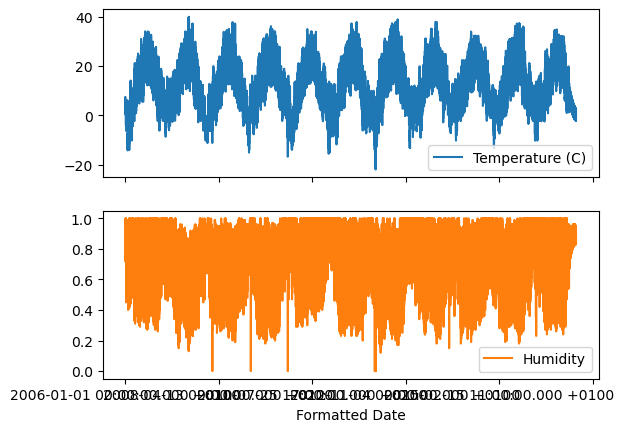

In [18]:
features.plot(subplots=True)

In [25]:
TRAIN_SPLIT = 70000

In [26]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [27]:
dataset = (dataset-data_mean)/data_std

In [28]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [29]:
past_history = 720
# future_target = 72 #12 hrs, observation every 10 minutes
# 6, 8, 12, 24 hrs -> 36, 48, 72, 144
targets = [36, 48, 72, 144]
STEP = 6
models = []
histories = []
future_target = 72

In [30]:
target_selection = dataset[:, 0] # dataset[:, 0] - temp, dataset[:, 1] - humidity
x_train_multi, y_train_multi = multivariate_data(dataset, target_selection, 0,
                                                TRAIN_SPLIT, past_history,
                                                future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, target_selection,
                                            TRAIN_SPLIT, None, past_history,
                                            future_target, STEP)
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(future_target))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

EPOCHS = 20
EVALUATION_INTERVAL = 200
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

hrs = future_target/6
path_name = "my_saved_lstm_for_temp" + str(hrs) + "hrsweatherds.keras"
multi_step_model.save(path_name)
models.append(multi_step_model)
histories.append(multi_step_history)


Epoch 1/20


c:\Users\YogaX1G2\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 51s 233ms/step - loss: 0.7396 - val_loss: 0.3807
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 36s 180ms/step - loss: 0.4107 - val_loss: 0.3685
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 35s 176ms/step - loss: 0.3799 - val_loss: 0.3230
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 33s 166ms/step - loss: 0.3323 - val_loss: 0.2974
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 35s 174ms/step - loss: 0.2909 - val_loss: 0.2521
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 30s 149ms/step - loss: 0.2762 - val_loss: 0.2502
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 29s 147ms/step - loss: 0.2649 - val_loss: 0.2314
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 44s 220ms/step - loss: 0.2558 - val_loss: 0.2542
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 42s 208ms/step - loss: 0.2547 - val_loss: 0.2301
Epoch 10/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 46s 229ms/step - loss: 0.2617 - val_loss: 0.2493
Epoch 11/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 36s 181ms/step - loss: 0.2560 - val_loss: 0.2259
Epoch 12/20
200/200 ━━━━━━━━━━

In [31]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 2)

 Target temperature to predict : (36,)


In [32]:
def create_time_steps(length):
  return list(range(-length, 0))

In [33]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

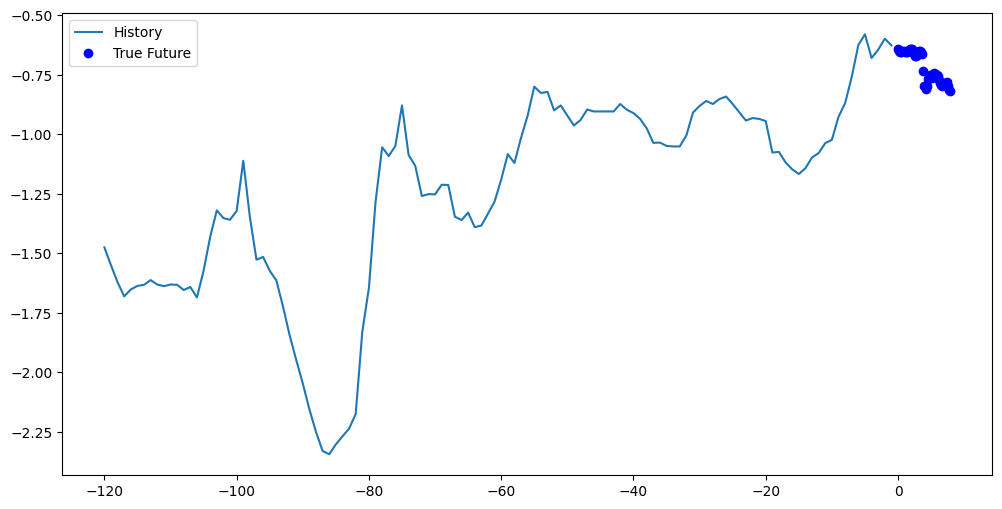

In [15]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [34]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
(256, 36)


In [17]:
from tensorflow.keras.models import load_model
model_path = "my_saved_lstm_6.0hrs.keras"
# Ładowanie modelu
model = load_model(model_path)


OSError: No file or directory found at my_saved_lstm_6.0hrs.keras

In [35]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

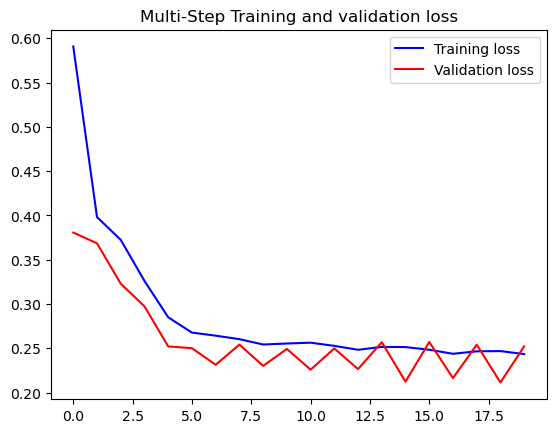

In [36]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


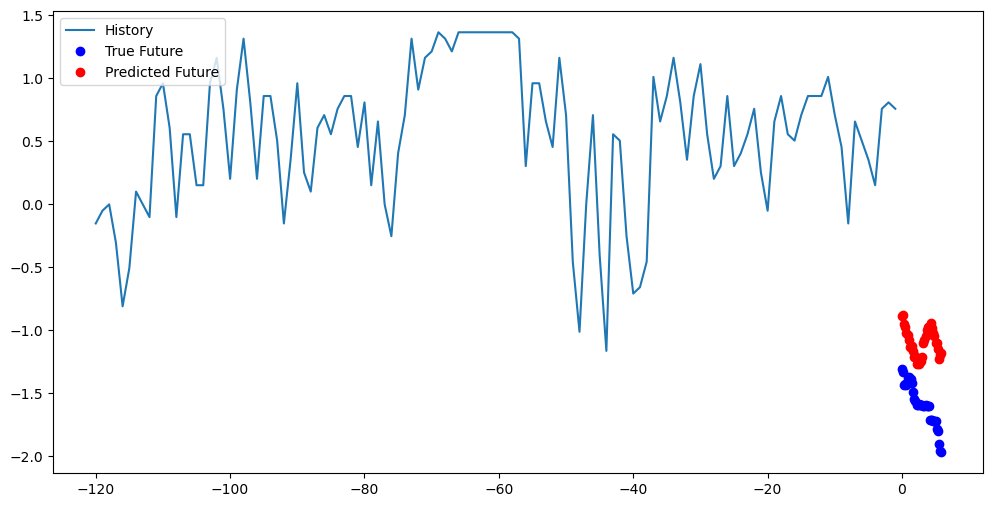

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


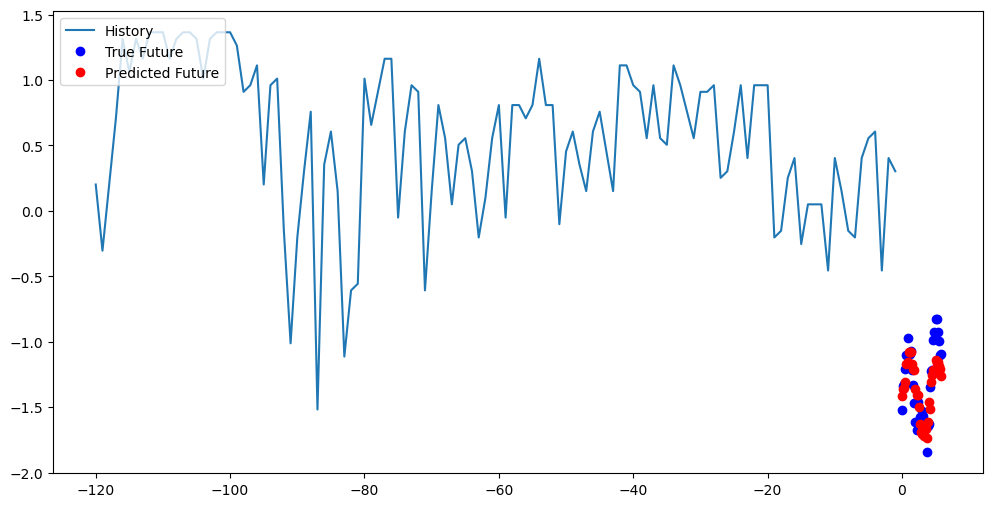

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


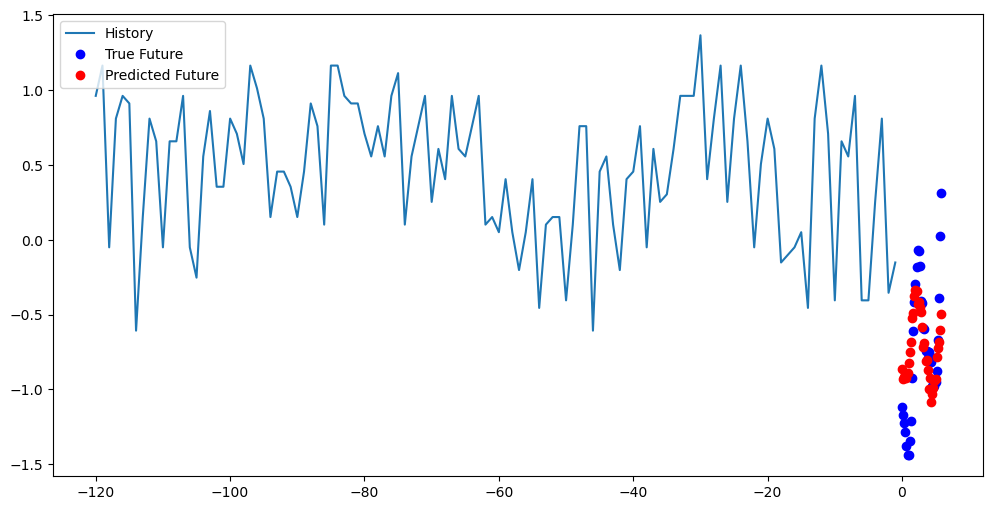

In [37]:
for x, y in val_data_multi.take(3):

  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])